## Logistic Regression Modelling: COVID-19 Dataset

#### Content
##### 1) Import Packages
##### 2) Reading Into Data
##### 3) Necessary Functions
##### 4) Train Test Splitting
##### 5) Scaling Data
##### 6) Dealing with Target Class Imbalance
##### 7) Logistic Regression: Random Under-Sampling
##### 8) Feature Selection: Logistic regression with Random Under-Sampling
##### 9) Logistic Regression: SMOTE Over-Sampling
##### 10) Logistic Regression: SMOTE and Feature Selection
##### 11) Logistic Regression: Random Under-Sampling and SMOTE
##### 12) Logistic Regression: Random under-sampling and SMOTE with Feature Selection
##### 13) Logistic Regression: PCA and Resampling Methods
##### 14) Logistic Regression PCA Randomly Under-Sampled
##### 15) Logistic Regression PCA SMOTE
##### 16) Logistic Regression PCA Under-Sampled and SMOTE
##### 17) Summary

#### 1) Import Packages

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

#### 2) Reading into data

In [23]:
df = pd.read_csv('COVID_Clean_Data_OHE.csv')

In [24]:
df.head()

,Unnamed: 0,USMER,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,...,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,MEDICAL_UNIT_8,MEDICAL_UNIT_9,MEDICAL_UNIT_10,MEDICAL_UNIT_11,MEDICAL_UNIT_12,MEDICAL_UNIT_13,DEATH
0,0,2,1,1,1,65,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1
1,1,2,2,1,1,72,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1
2,2,2,2,2,2,55,2,1,2,2,...,0,0,0,0,0,0,0,0,0,1
3,3,2,1,1,2,53,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1
4,4,2,2,1,2,68,2,1,2,2,...,0,0,0,0,0,0,0,0,0,1


In [25]:
df.shape

(1021977, 38)

In [26]:
df.dtypes

Unnamed: 0                int64
USMER                     int64
SEX                       int64
PATIENT_TYPE              int64
PNEUMONIA                 int64
AGE                       int64
PREGNANT                  int64
DIABETES                  int64
COPD                      int64
ASTHMA                    int64
INMSUPR                   int64
HIPERTENSION              int64
OTHER_DISEASE             int64
CARDIOVASCULAR            int64
OBESITY                   int64
RENAL_CHRONIC             int64
TOBACCO                   int64
CLASIFFICATION_FINAL_1    int64
CLASIFFICATION_FINAL_2    int64
CLASIFFICATION_FINAL_3    int64
CLASIFFICATION_FINAL_4    int64
CLASIFFICATION_FINAL_5    int64
CLASIFFICATION_FINAL_6    int64
CLASIFFICATION_FINAL_7    int64
MEDICAL_UNIT_1            int64
MEDICAL_UNIT_2            int64
MEDICAL_UNIT_3            int64
MEDICAL_UNIT_4            int64
MEDICAL_UNIT_5            int64
MEDICAL_UNIT_6            int64
MEDICAL_UNIT_7            int64
MEDICAL_

In [27]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [28]:
df.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2',
       'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4',
       'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6',
       'CLASIFFICATION_FINAL_7', 'MEDICAL_UNIT_1', 'MEDICAL_UNIT_2',
       'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9', 'MEDICAL_UNIT_10',
       'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12', 'MEDICAL_UNIT_13', 'DEATH'],
      dtype='object')

#### 3) Necessary Functions

In [29]:
def scaling(train,test,scaler_class):
    """Standardizing/scaling the data. Assumes all columns need to be scaled."""
    cols = train.columns
    scaler = scaler_class

    index_train = train.index
    train = scaler.fit_transform(train)
    train = pd.DataFrame(train, columns=cols,index=index_train)

    index_test = test.index
    test = scaler.transform(test)
    test = pd.DataFrame(test,columns=cols,index=index_test)

    return train, test

In [30]:
def cutoff_iterator(X,y,iterations,accuracy=[],precision=[],f1_score=[]):
    """Works through many cutoff points and outputs precision and recall scores.
    Requires sklearn metrics package."""
    for i in iterations:
        X['y_pred'] = np.where(X['prob_die']>i, 1, 0)
        accuracy.append(metrics.accuracy_score(y,X['y_pred']))
        precision.append(metrics.precision_score(y,X['y_pred']))
        f1_score.append(metrics.f1_score(y,X['y_pred']))
    dict_2 = {'Cut_Off_Points':iterations,
              'Accuracy':accuracy,
              'Precision':precision,
              'F1':f1_score}
    metrics_table = pd.DataFrame(dict_2)
    return metrics_table

In [31]:
def drop(X):
    for i in ['DEATH','prob_survive','prob_die','y_pred']:
        try:
            X.drop(columns=i,inplace=True)
        except KeyError:
            print(f'Column {i} doesn\'t exist')
            continue

#### 4) Train test splitting

In [32]:
features = ['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT',
            'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
            'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
            'TOBACCO', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2',
            'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4',
            'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6',
            'CLASIFFICATION_FINAL_7', 'MEDICAL_UNIT_1', 'MEDICAL_UNIT_2',
            'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
            'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9', 'MEDICAL_UNIT_10',
            'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12', 'MEDICAL_UNIT_13']
X = df[features]
y = df['DEATH']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
### Stratify y to get equal distribution of 'DEATH' values in train and test

In [34]:
lst = [X_train,X_test,y_train,y_test]
for x in lst:
    print(x.shape)

(817581, 36)
(204396, 36)
(817581,)
(204396,)


#### 5) Scaling data
##### It is suggested that standardization is good for Logistic Regression (https://towardsdatascience.com/logistic-regression-and-the-feature-scaling-ensemble-e78a56fc6c1).

In [35]:
X_train, X_test = scaling(train=X_train,test=X_test,scaler_class = StandardScaler())

In [36]:
X_train.head()

,USMER,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,...,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,MEDICAL_UNIT_8,MEDICAL_UNIT_9,MEDICAL_UNIT_10,MEDICAL_UNIT_11,MEDICAL_UNIT_12,MEDICAL_UNIT_13
166815,0.747241,-1.002607,-0.480459,0.394370,-0.590822,0.087734,0.368068,0.119863,0.175206,0.115782,...,1.526691,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,-1.167162,-0.028033
46083,0.747241,-1.002607,2.081344,-2.535689,1.080969,0.087734,-2.716890,0.119863,0.175206,0.115782,...,1.526691,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,-1.167162,-0.028033
800285,0.747241,-1.002607,-0.480459,0.394370,-0.471408,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033
544230,-1.338257,-1.002607,-0.480459,0.394370,-0.590822,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033
603178,-1.338257,0.997399,-0.480459,0.394370,-0.889356,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033


In [37]:
X_test.head()

,USMER,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,...,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,MEDICAL_UNIT_8,MEDICAL_UNIT_9,MEDICAL_UNIT_10,MEDICAL_UNIT_11,MEDICAL_UNIT_12,MEDICAL_UNIT_13
134042,0.747241,-1.002607,2.081344,-2.535689,1.200383,0.087734,0.368068,0.119863,0.175206,0.115782,...,1.526691,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,-1.167162,-0.028033
834875,0.747241,0.997399,-0.480459,0.394370,-1.068477,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033
474995,-1.338257,0.997399,-0.480459,0.394370,1.618331,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033
530436,0.747241,0.997399,-0.480459,0.394370,-0.232581,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033
579946,-1.338257,0.997399,-0.480459,0.394370,-1.247597,0.087734,0.368068,0.119863,0.175206,0.115782,...,-0.655012,-0.083278,-0.195676,-0.029502,-0.099951,-0.194189,-0.086551,-0.074111,0.856779,-0.028033


#### 6) Dealing with Target Class Imbalance
##### Under-sampling and Over-sampling: we could over-sample the minority class at the potential cost of over-fitting because very similar instances of the minority class are repeated more times, reinforcing a relationship when it may not necessarily be present. Under-sampling could be done at the cost of losing information by reducing the variability of information that is present in the majority sample. Could also combine both, so over-sampling the minority from 1:100 to 1:5 ratio and from there under-sampling the majority to equal ratio (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Random%20oversampling%20duplicates%20examples%20from,information%20invaluable%20to%20a%20model).
##### SMOTE: Synthetic Minority Over-sampling Technique. It is said that SMOTE reduces the variability of the minority class which is not something we want. SMOTE has been reported to reduce class imbalance effectively for low-dimensional data which is consistent with our number of features. As the class imbalance was a step larger the reduction in bias for either effect increased with increasing sample size (although it was not a million). These results are based on testing prediction balance of K-Nearest Neighbour and Random Forests, among other models (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/). We are planning to use these models for this data.
##### Another resource mentions that when we have loads of data (in the millions range) we can use under-sampling but again at the cost of information loss, says pretty much the same as the first source (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

##### A source says that a combination of both under-sampling and over-sampling methods could be good. There are many ways, we will compare a few of them (https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/).

##### I will compare the random under-sampling against SMOTE against random under-sampling and SMOTE.

### Resampling the data
##### Source: https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/
##### ONLY resampling the train data, otherwise we would artificially inflate our metrics. We want the train data to be adjusted so that the model can fit better. Our test data should not be affected because it must reflect real life data.
#### Random Under-Sampling

In [38]:
under_base = RandomUnderSampler(sampling_strategy=1,random_state=42)### we want the majority to reduce till it is the size of the minority

In [39]:
X_train_u,y_train_u = under_base.fit_resample(X_train,y_train)

In [40]:
y_train_u.value_counts()

0    59726
1    59726
Name: DEATH, dtype: int64

#### SMOTE

In [41]:
smote = SMOTE(sampling_strategy = 1,random_state=42)

In [42]:
X_train_s,y_train_s = smote.fit_resample(X_train,y_train)

In [43]:
y_train_s.value_counts()

0    757855
1    757855
Name: DEATH, dtype: int64

#### Under-sampling and SMOTE Combination

In [44]:
under_half = RandomUnderSampler(sampling_strategy=0.5,random_state=42)

In [45]:
X_train_us,y_train_us = under_half.fit_resample(X_train,y_train)

In [46]:
X_train_us,y_train_us = smote.fit_resample(X_train_us,y_train_us)

In [47]:
y_train_us.value_counts()

0    119452
1    119452
Name: DEATH, dtype: int64

#### 7) Logistic Regression: Random Under-Sampling

In [48]:
drop(X_train_u)

Column DEATH doesn't exist
Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


In [49]:
lr = LogisticRegression(max_iter=100, random_state=42)
lr.fit(X_train_u,y_train_u)

LogisticRegression(random_state=42)

In [50]:
X_train_u[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_u)

In [51]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
cutoff_iterator(X = X_train_u,y = y_train_u,iterations = iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.785052,0.700431,0.822518
1,0.10,0.863770,0.790698,0.878980
2,0.15,0.893530,0.833911,0.902256
3,0.20,0.905510,0.856038,0.911648
4,0.25,0.911621,0.870600,0.916256
5,0.30,0.913605,0.879066,0.917370
6,0.35,0.913815,0.885367,0.916883
7,0.40,0.913153,0.890122,0.915643
8,0.45,0.911898,0.894639,0.913783
9,0.50,0.909319,0.897784,0.910615


##### Test data
##### We had the best precision whilst maintaining f1_score above 0.75 when the cut_off point was 0.85

In [52]:
X_test[['prob_survive', 'prob_die']] = lr.predict_proba(X_test)
X_test['y_pred'] = np.where(X_test['prob_die']>0.9, 1, 0)

In [53]:
metrics.precision_score(y_test,X_test['y_pred'])

0.546081898026691

In [54]:
metrics.f1_score(y_test,X_test['y_pred'])

0.5898660095487448

##### Precision score and f1_score both experienced a huge drop-off comparing to train data, indicating that the model is very over-fit.

#### 8) Feature Selection: Logistic regression with Random Under-Sampling
##### Feature selection will be based on the training data correlations with 'DEATH'

In [55]:
X_train_u.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2',
       'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4',
       'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6',
       'CLASIFFICATION_FINAL_7', 'MEDICAL_UNIT_1', 'MEDICAL_UNIT_2',
       'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9', 'MEDICAL_UNIT_10',
       'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12', 'MEDICAL_UNIT_13', 'prob_survive',
       'prob_die', 'y_pred'],
      dtype='object')

In [56]:
drop(X_train_u)

Column DEATH doesn't exist


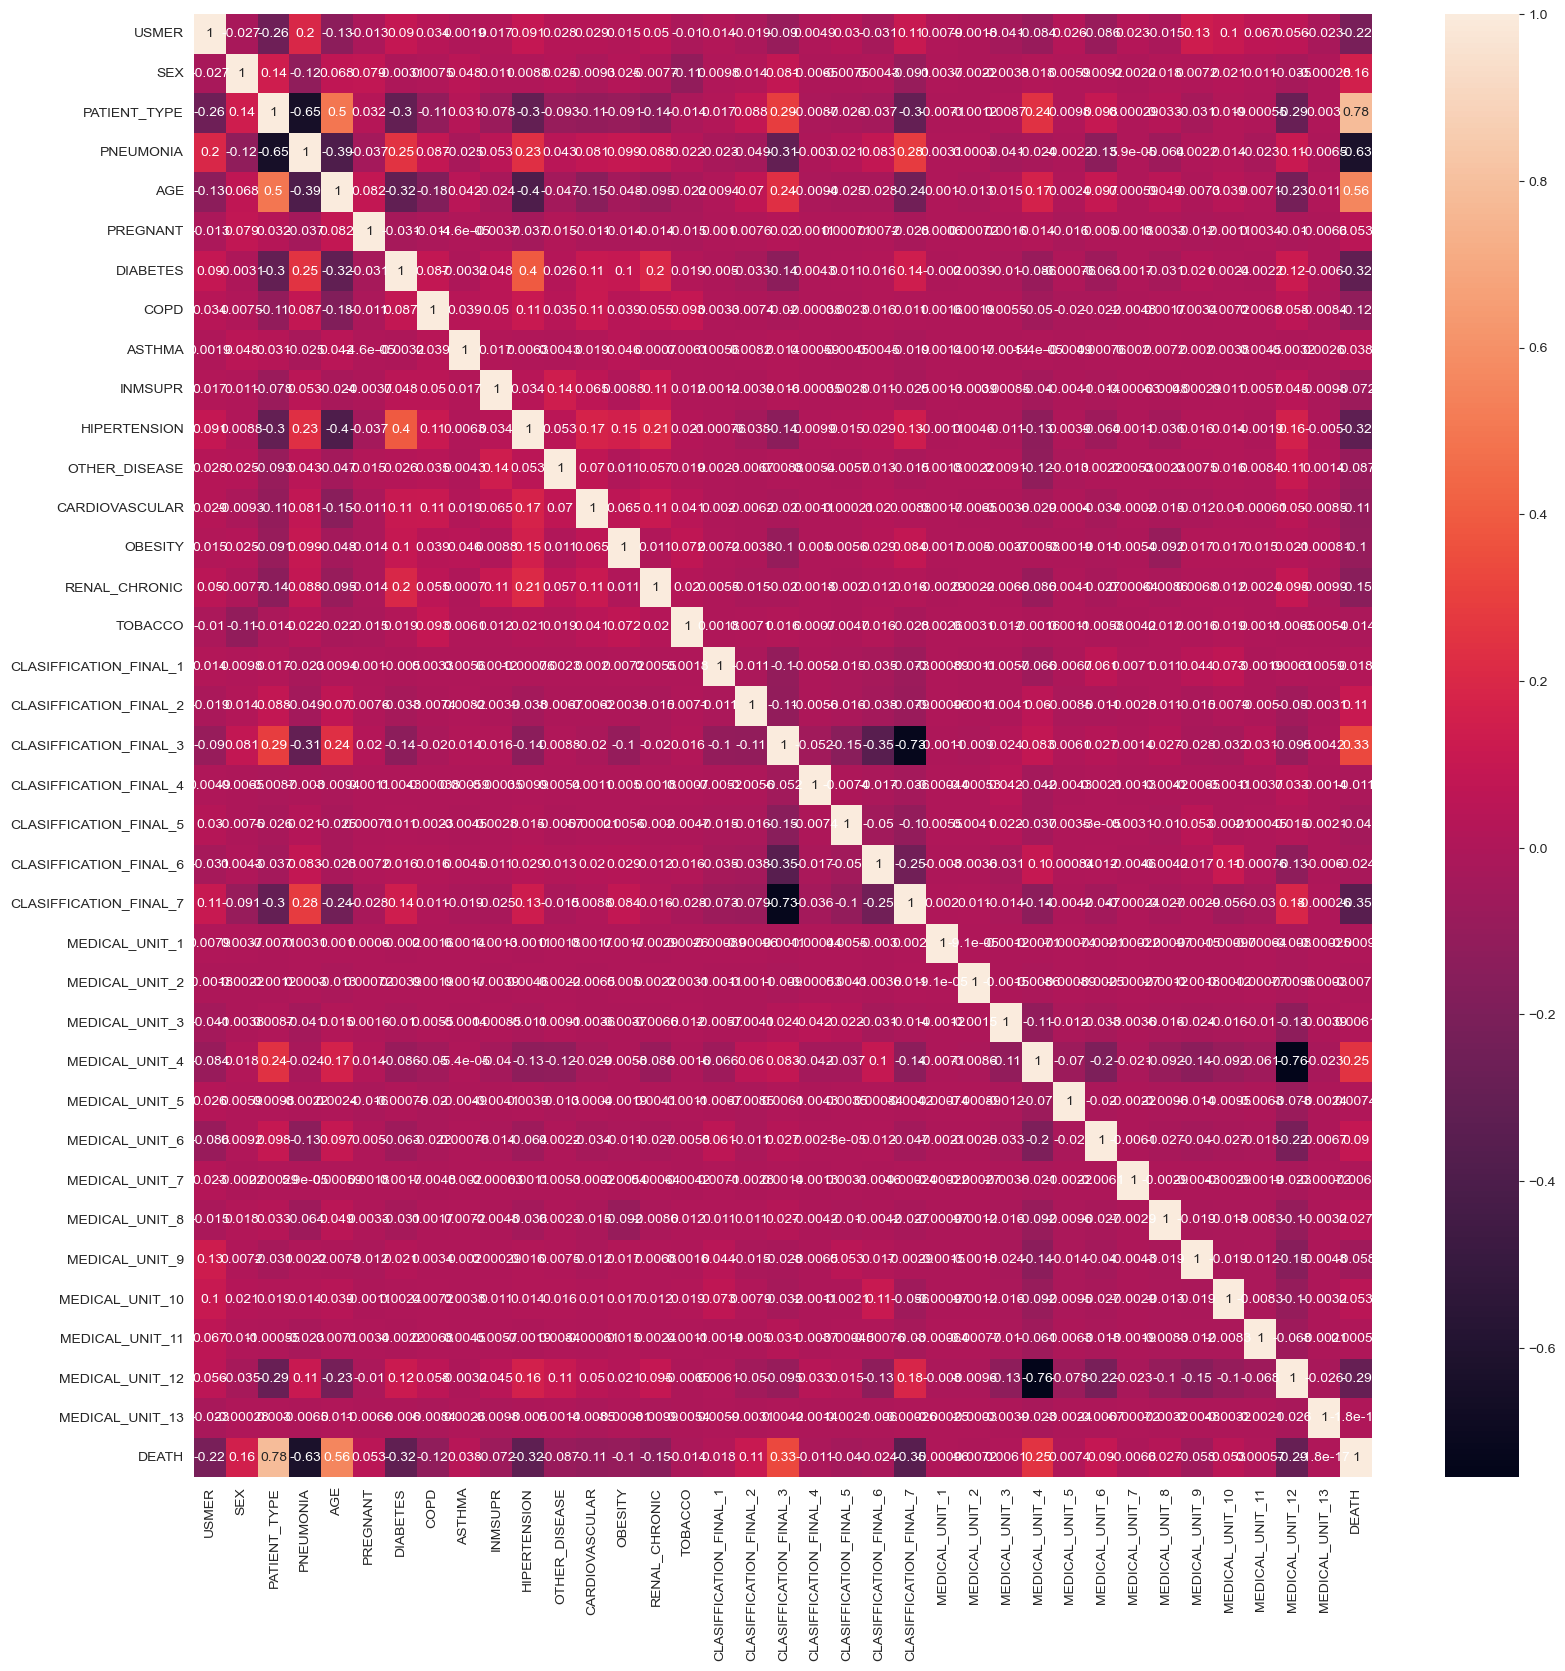

In [57]:
X_train_u['DEATH'] = y_train_u

plt.figure(figsize=(19,19))
sns.heatmap(data = X_train_u.corr(),
            annot = True)
plt.show()

In [58]:
drop(X_train_u)

Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


##### To attempt to deal with over-fitting, we can select the features strictly. We now select the features that are considered to have high correlation: 'PATIENT_TYPE', 'PNEUMONIA' and 'AGE' (https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/#:~:text=High%20degree%3A%20If%20the%20coefficient,to%20be%20a%20small%20correlation).

In [59]:
selected = ['PATIENT_TYPE', 'PNEUMONIA', 'AGE']
X_train_u_select = X_train_u.copy()[selected]
X_train_u_select.head()

,PATIENT_TYPE,PNEUMONIA,AGE
0,-0.480459,0.394370,0.185367
1,-0.480459,-2.535689,-0.113167
2,-0.480459,0.394370,-0.710236
3,2.081344,0.394370,-0.829649
4,-0.480459,0.394370,-1.068477


In [60]:
lr.fit(X_train_u_select,y_train_u)
X_train_u_select[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_u_select)

In [61]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_u_select, y=y_train_u, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.731842,0.651798,0.787792
1,0.10,0.844816,0.768875,0.864019
2,0.15,0.884020,0.825527,0.893581
3,0.20,0.898093,0.851958,0.904361
4,0.25,0.902379,0.863407,0.907347
5,0.30,0.903886,0.870631,0.908013
6,0.35,0.904154,0.876687,0.907525
7,0.40,0.903350,0.881354,0.906060
8,0.45,0.901776,0.887234,0.903587
9,0.50,0.899575,0.890219,0.900764


##### The best cut_off point yielding the best precision when f1_score above 0.75 is 0.85.

In [56]:
X_test_select = X_test.copy()[selected]
X_test_select[['prob_survive', 'prob_die']] = lr.predict_proba(X_test_select)
X_test_select['y_pred'] = np.where(X_test_select['prob_die']>0.85, 1, 0)

In [57]:
metrics.precision_score(y_test,X_test_select['y_pred'])

0.4708294747982537

In [58]:
metrics.f1_score(y_test,X_test_select['y_pred'])

0.5678047223994894

##### The data is over-fitting after more strict feature selection and the precision and accuracy scores are poor.

#### 9) Logistic Regression: SMOTE Over-Sampling

In [62]:
lr.fit(X_train_s,y_train_s)
X_train_s[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_s)

In [63]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_s, y=y_train_s, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.798019,0.713334,0.831470
1,0.10,0.871294,0.799755,0.885015
2,0.15,0.898170,0.839863,0.906215
3,0.20,0.909266,0.860519,0.915011
4,0.25,0.913860,0.872914,0.918343
5,0.30,0.915832,0.881026,0.919509
6,0.35,0.915968,0.886718,0.919030
7,0.40,0.915476,0.891339,0.918005
8,0.45,0.913943,0.895123,0.915945
9,0.50,0.911776,0.898444,0.913228


In [64]:
drop(X_test)

Column DEATH doesn't exist


In [65]:
X_test[['prob_survive', 'prob_die']] = lr.predict_proba(X_test)
X_test['y_pred'] = np.where(X_test['prob_die']>0.9, 1, 0)

In [66]:
metrics.precision_score(y_test,X_test['y_pred'])

0.5491949910554562

In [67]:
metrics.f1_score(y_test,X_test['y_pred'])

0.590018598884067

#### 10) Logistic Regression: SMOTE and Feature Selection

In [68]:
drop(X_train_s)

Column DEATH doesn't exist


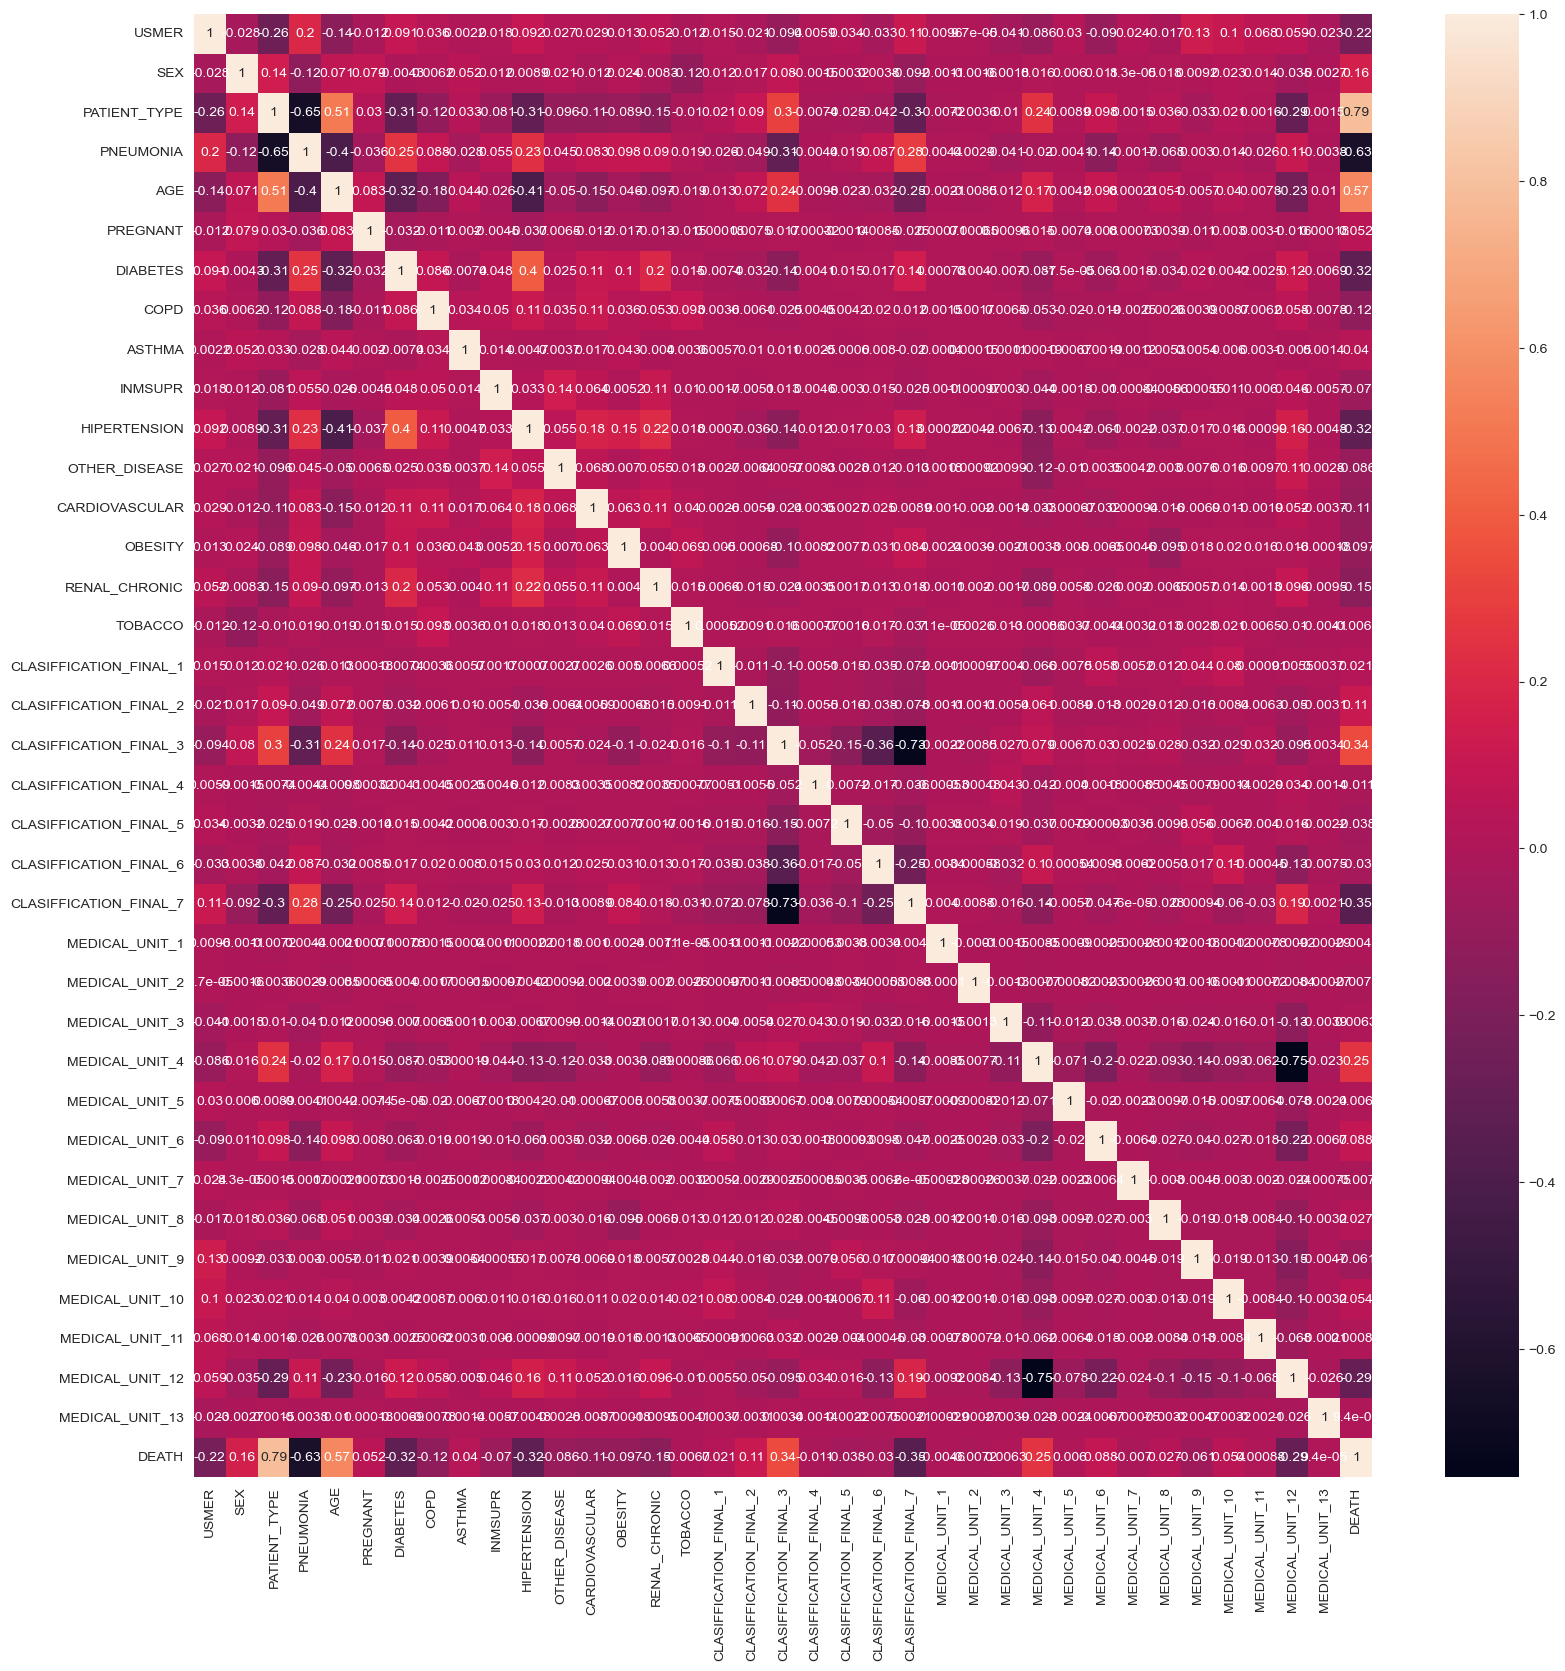

In [69]:
X_train_s['DEATH'] = y_train_s

plt.figure(figsize=(19,19))
sns.heatmap(data = X_train_s.corr(),
            annot = True)
plt.show()

In [70]:
drop(X_train_s)

Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


In [71]:
selected = ['PATIENT_TYPE', 'PNEUMONIA', 'AGE']
X_train_s_select = X_train_s.copy()[selected]
X_train_s_select.head()

,PATIENT_TYPE,PNEUMONIA,AGE
0,-0.480459,0.394370,-0.590822
1,2.081344,-2.535689,1.080969
2,-0.480459,0.394370,-0.471408
3,-0.480459,0.394370,-0.590822
4,-0.480459,0.394370,-0.889356


In [72]:
lr.fit(X_train_s_select,y_train_s)
X_train_s_select[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_s_select)

In [73]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_s_select, y=y_train_s, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.750539,0.668028,0.799714
1,0.10,0.857159,0.783680,0.873538
2,0.15,0.890864,0.834488,0.899347
3,0.20,0.901183,0.855057,0.907210
4,0.25,0.905229,0.865958,0.910055
5,0.30,0.906693,0.872764,0.910755
6,0.35,0.906951,0.878078,0.910374
7,0.40,0.906521,0.884238,0.909155
8,0.45,0.904957,0.888057,0.906982
9,0.50,0.903374,0.892021,0.904753


In [74]:
drop(X_test)

Column DEATH doesn't exist


In [75]:
X_test_select = X_test.copy()[selected]
X_test_select[['prob_survive', 'prob_die']] = lr.predict_proba(X_test_select)
X_test_select['y_pred'] = np.where(X_test_select['prob_die']>0.85, 1, 0)

In [76]:
metrics.precision_score(y_test,X_test_select['y_pred'])

0.47316050153942263

In [77]:
metrics.f1_score(y_test,X_test_select['y_pred'])

0.567939585453377

#### 11) Logistic Regression: Random Under-Sampling and SMOTE

In [78]:
lr.fit(X_train_us,y_train_us)
X_train_us[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_us)

In [79]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_us, y=y_train_us, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.793674,0.709001,0.828429
1,0.10,0.868550,0.796478,0.882796
2,0.15,0.897193,0.838676,0.905368
3,0.20,0.908612,0.859674,0.914433
4,0.25,0.913484,0.872375,0.918010
5,0.30,0.915740,0.880982,0.919416
6,0.35,0.915937,0.887032,0.918963
7,0.40,0.915355,0.891551,0.917852
8,0.45,0.913677,0.895439,0.915622
9,0.50,0.911299,0.898764,0.912672


In [80]:
drop(X_test)

Column DEATH doesn't exist
Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


In [81]:
X_test[['prob_survive', 'prob_die']] = lr.predict_proba(X_test)
X_test['y_pred'] = np.where(X_test['prob_die']>0.9, 1, 0)

In [82]:
metrics.precision_score(y_test,X_test['y_pred'])

0.5468526670859299

In [83]:
metrics.f1_score(y_test,X_test['y_pred'])

0.5900314601196718

#### 12) Logistic Regression: Random under-sampling and SMOTE with Feature Selection

In [84]:
X_train_us.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2',
       'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4',
       'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6',
       'CLASIFFICATION_FINAL_7', 'MEDICAL_UNIT_1', 'MEDICAL_UNIT_2',
       'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9', 'MEDICAL_UNIT_10',
       'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12', 'MEDICAL_UNIT_13', 'prob_survive',
       'prob_die', 'y_pred'],
      dtype='object')

In [85]:
drop(X_train_us)

Column DEATH doesn't exist


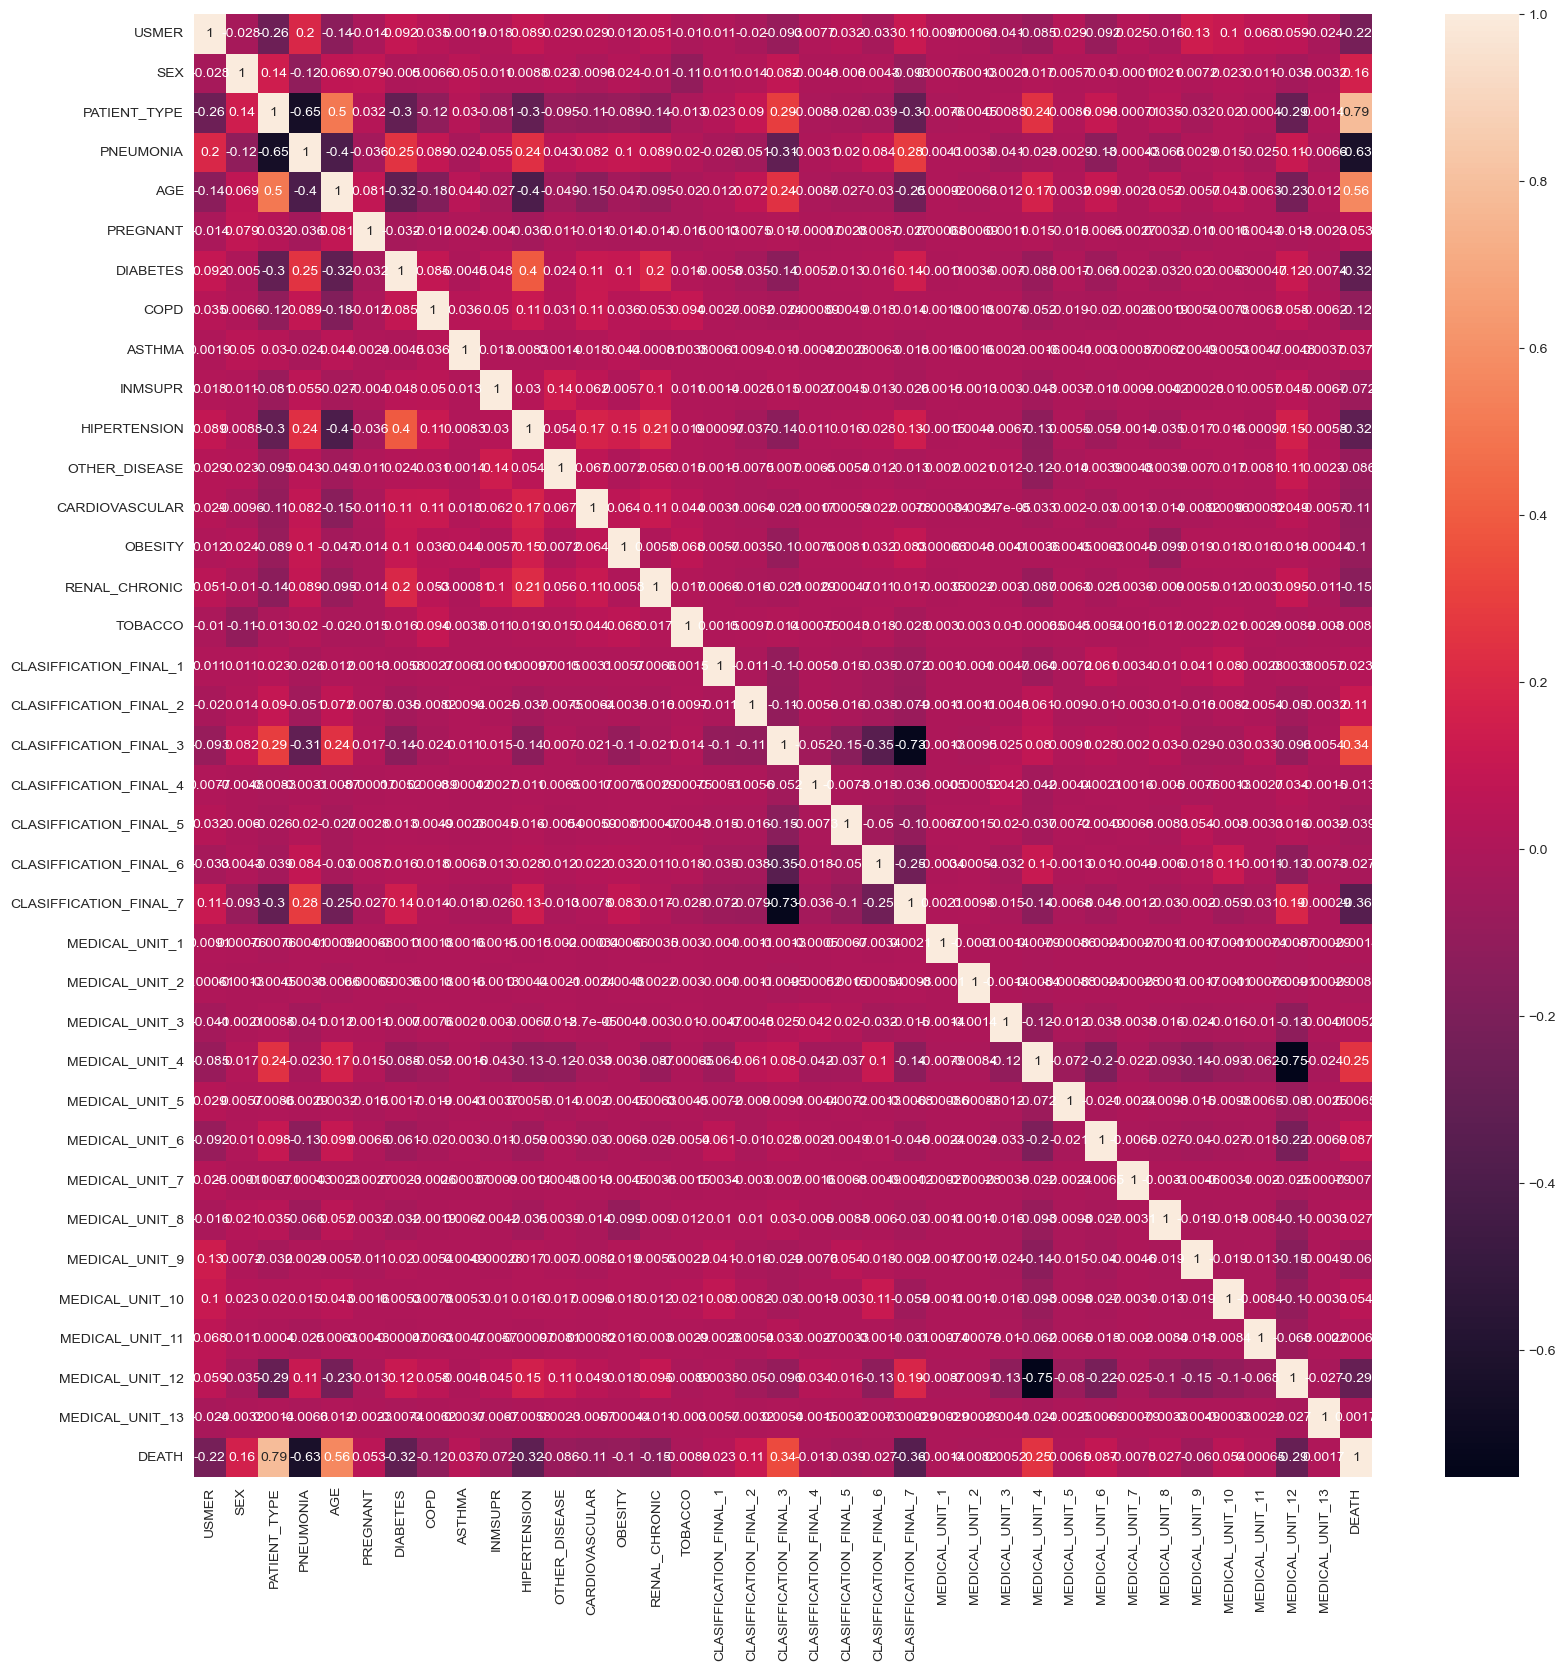

In [86]:
X_train_us['DEATH'] = y_train_us

plt.figure(figsize=(19,19))
sns.heatmap(data = X_train_us.corr(),
            annot = True)
plt.show()

In [87]:
drop(X_train_us)

Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


In [88]:
selected = ['PATIENT_TYPE', 'PNEUMONIA', 'AGE']
X_train_us_select = X_train_us.copy()[selected]
X_train_us_select.head()

,PATIENT_TYPE,PNEUMONIA,AGE
0,-0.480459,0.394370,0.185367
1,-0.480459,-2.535689,-0.113167
2,-0.480459,0.394370,-0.710236
3,2.081344,0.394370,-0.829649
4,-0.480459,0.394370,-1.068477


In [89]:
lr.fit(X_train_us_select, y_train_us)
X_train_us_select[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_us_select)

In [90]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_us_select, y=y_train_us, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.741335,0.659937,0.793806
1,0.10,0.851752,0.776983,0.869382
2,0.15,0.888244,0.830838,0.897166
3,0.20,0.899734,0.853137,0.905940
4,0.25,0.904179,0.864812,0.909084
5,0.30,0.906159,0.872800,0.910178
6,0.35,0.906360,0.878056,0.909739
7,0.40,0.905259,0.883474,0.907876
8,0.45,0.903819,0.888125,0.905725
9,0.50,0.902090,0.892031,0.903331


In [91]:
X_test_select = X_test.copy()[selected]
X_test_select[['prob_survive', 'prob_die']] = lr.predict_proba(X_test_select)
X_test_select['y_pred'] = np.where(X_test_select['prob_die']>0.85, 1, 0)

In [92]:
metrics.precision_score(y_test,X_test_select['y_pred'])

0.47316050153942263

In [93]:
metrics.f1_score(y_test,X_test_select['y_pred'])

0.567939585453377

#### 13) Logistic Regression: PCA and Resampling Methods
##### Note: PCA is only really useful when there are more features than samples or most of the features are highly correlated with each other. Neither of these is the case for this data, however I will still experiment with PCA.
##### Under-sampled

In [111]:
X_train_u.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2',
       'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4',
       'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6',
       'CLASIFFICATION_FINAL_7', 'MEDICAL_UNIT_1', 'MEDICAL_UNIT_2',
       'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9', 'MEDICAL_UNIT_10',
       'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12', 'MEDICAL_UNIT_13'],
      dtype='object')

In [112]:
drop(X_train_u)

Column DEATH doesn't exist
Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


In [113]:
X_train_u.columns

Index(['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'AGE', 'PREGNANT',
       'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
       'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
       'TOBACCO', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2',
       'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4',
       'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6',
       'CLASIFFICATION_FINAL_7', 'MEDICAL_UNIT_1', 'MEDICAL_UNIT_2',
       'MEDICAL_UNIT_3', 'MEDICAL_UNIT_4', 'MEDICAL_UNIT_5', 'MEDICAL_UNIT_6',
       'MEDICAL_UNIT_7', 'MEDICAL_UNIT_8', 'MEDICAL_UNIT_9', 'MEDICAL_UNIT_10',
       'MEDICAL_UNIT_11', 'MEDICAL_UNIT_12', 'MEDICAL_UNIT_13'],
      dtype='object')

In [114]:
def PCA_(X_train):
    pca = PCA(n_components=X_train.shape[1],random_state=42)
    pca.fit_transform(X_train)
    #Plotting
    out_sum = np.cumsum(pca.explained_variance_ratio_)
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, out_sum, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Proportion of Variance Explained')
    plt.show()

    print ("Cumulative Prop. Variance Explained: ", out_sum)

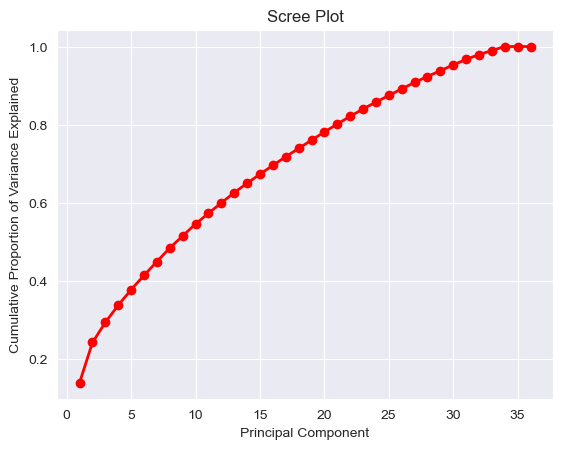

Cumulative Prop. Variance Explained:  [0.13968754 0.24216514 0.29376684 0.33775579 0.37741364 0.41398944
 0.44932048 0.48418086 0.51495861 0.54566264 0.57291815 0.59963864
 0.62571903 0.65002676 0.67300718 0.69568365 0.71774392 0.7390458
 0.76027092 0.78103388 0.80154542 0.82107579 0.84019968 0.85756365
 0.87462557 0.89148073 0.90798737 0.9232072  0.93811356 0.95284675
 0.96707826 0.97928992 0.98971577 1.         1.         1.        ]


In [115]:
PCA_(X_train_u)

In [116]:
drop(X_train_u)

Column DEATH doesn't exist
Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


In [117]:
drop(X_test)

Column DEATH doesn't exist


In [118]:
#### The 21st component explains more than 80% of the variance
pca = PCA(n_components=21,random_state=42)
X_train_u_pca = pca.fit_transform(X_train_u)
X_test_u_pca = pca.transform(X_test)

In [119]:
X_train_u_pca = pd.DataFrame(X_train_u_pca)
X_test_u_pca = pd.DataFrame(X_test_u_pca)

##### SMOTE

In [120]:
drop(X_train_s)

Column DEATH doesn't exist
Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


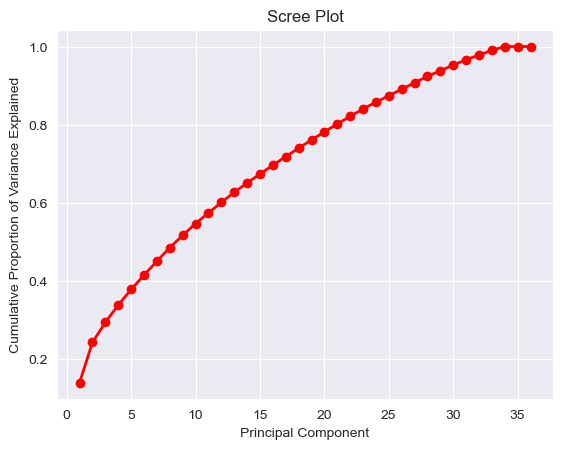

Cumulative Prop. Variance Explained:  [0.13988579 0.24272555 0.29405385 0.33820106 0.37800523 0.41492534
 0.45035224 0.48534705 0.51624182 0.54690804 0.5740962  0.60071774
 0.62680184 0.65075926 0.67356623 0.69627791 0.71824491 0.7397777
 0.76087282 0.78151411 0.80184925 0.82116629 0.84030307 0.8572992
 0.87408389 0.89073826 0.90728161 0.9234551  0.93813223 0.95247598
 0.96618798 0.97816476 0.9900676  1.         1.         1.        ]


In [121]:
PCA_(X_train_s)

In [122]:
#### The 12th component explains more than 80% of the variance
pca = PCA(n_components=21,random_state=42)
X_train_s_pca = pca.fit_transform(X_train_s)
X_test_s_pca = pca.transform(X_test)

In [123]:
X_train_s_pca = pd.DataFrame(X_train_s_pca)
X_test_s_pca = pd.DataFrame(X_test_s_pca)

##### Under-sampling and SMOTE

In [124]:
drop(X_train_us)

Column DEATH doesn't exist
Column prob_survive doesn't exist
Column prob_die doesn't exist
Column y_pred doesn't exist


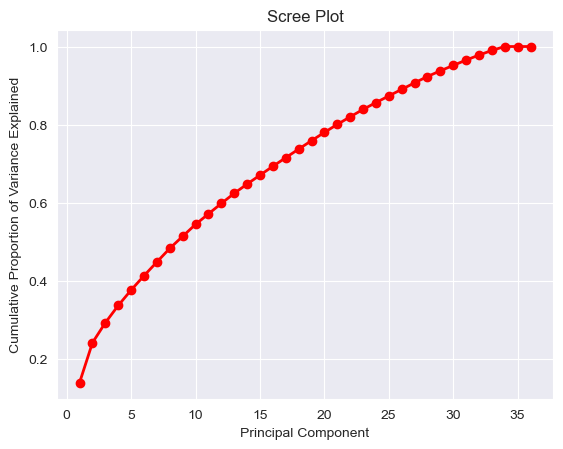

Cumulative Prop. Variance Explained:  [0.13968639 0.24171224 0.29285022 0.33697034 0.37643959 0.41312106
 0.44832678 0.4832203  0.51399233 0.54455433 0.57146907 0.59813227
 0.62404543 0.64771602 0.67061897 0.69322707 0.71538121 0.73726136
 0.75891024 0.78001578 0.80057174 0.81992585 0.83903214 0.85635242
 0.8734741  0.89034456 0.90693592 0.9232048  0.93778652 0.95162056
 0.96530738 0.97805469 0.98995518 1.         1.         1.        ]


In [125]:
PCA_(X_train_us)

In [126]:
#### The 12th component explains more than 80% of the variance
pca = PCA(n_components=21,random_state=42)
X_train_us_pca = pca.fit_transform(X_train_us)
X_test_us_pca = pca.transform(X_test)

In [127]:
X_train_us_pca = pd.DataFrame(X_train_us_pca)
X_test_us_pca = pd.DataFrame(X_test_us_pca)

#### 14) Logistic Regression PCA Randomly Under-Sampled

In [128]:
lr.fit(X_train_u_pca,y_train_u)
X_train_u_pca[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_u_pca)

In [129]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_u_pca, y=y_train_u, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.776898,0.692338,0.817102
1,0.10,0.857047,0.781890,0.873862
2,0.15,0.888985,0.827011,0.898594
3,0.20,0.903300,0.851125,0.909988
4,0.25,0.909654,0.865517,0.914798
5,0.30,0.912567,0.875396,0.916692
6,0.35,0.913631,0.882488,0.917009
7,0.40,0.912969,0.887997,0.915683
8,0.45,0.911052,0.892237,0.913136
9,0.50,0.908390,0.895998,0.909801


In [103]:
X_test_u_pca[['prob_survive', 'prob_die']] = lr.predict_proba(X_test_u_pca)
X_test_u_pca['y_pred'] = np.where(X_test_u_pca['prob_die']>0.85, 1, 0)

In [104]:
metrics.precision_score(y_test,X_test_u_pca['y_pred'])

0.5011443785323929

In [105]:
metrics.f1_score(y_test,X_test_u_pca['y_pred'])

0.5904788112272977

#### 15) Logistic Regression PCA SMOTE

In [130]:
lr.fit(X_train_s_pca,y_train_s)
X_train_s_pca[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_s_pca)

In [131]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_s_pca, y=y_train_s, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.793009,0.708210,0.828029
1,0.10,0.868076,0.795563,0.882491
2,0.15,0.895481,0.835845,0.904004
3,0.20,0.907504,0.857295,0.913576
4,0.25,0.912686,0.870188,0.917426
5,0.30,0.914828,0.878560,0.918721
6,0.35,0.915319,0.884857,0.918543
7,0.40,0.914736,0.889591,0.917401
8,0.45,0.913155,0.893543,0.915266
9,0.50,0.910862,0.897215,0.912368


In [108]:
X_test_s_pca[['prob_survive', 'prob_die']] = lr.predict_proba(X_test_s_pca)
X_test_s_pca['y_pred'] = np.where(X_test_s_pca['prob_die']>0.90, 1, 0)

In [109]:
metrics.precision_score(y_test,X_test_s_pca['y_pred'])

0.543063735494781

In [110]:
metrics.f1_score(y_test,X_test_s_pca['y_pred'])

0.5806109725685786

#### 16) Logistic Regression PCA Under-Sampled and SMOTE

In [132]:
lr.fit(X_train_us_pca,y_train_us)
X_train_us_pca[['prob_survive', 'prob_die']] = lr.predict_proba(X_train_us_pca)

In [133]:
iterations = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
              0.90, 0.95]
cutoff_iterator(X=X_train_us_pca, y=y_train_us, iterations=iterations, accuracy=[], precision=[], f1_score=[])

,Cut_Off_Points,Accuracy,Precision,F1
0,0.05,0.786584,0.701772,0.823647
1,0.10,0.863811,0.790169,0.879147
2,0.15,0.893719,0.833335,0.902546
3,0.20,0.906812,0.855954,0.913025
4,0.25,0.912429,0.869221,0.917270
5,0.30,0.914903,0.877913,0.918873
6,0.35,0.915389,0.884357,0.918672
7,0.40,0.914836,0.889653,0.917502
8,0.45,0.913271,0.894020,0.915339
9,0.50,0.910701,0.897748,0.912131


In [134]:
X_test_us_pca[['prob_survive', 'prob_die']] = lr.predict_proba(X_test_us_pca)
X_test_us_pca['y_pred'] = np.where(X_test_us_pca['prob_die']>0.90, 1, 0)

In [135]:
metrics.precision_score(y_test,X_test_us_pca['y_pred'])

0.5405941749839491

In [136]:
metrics.f1_score(y_test,X_test_us_pca['y_pred'])

0.5777195608782436

#### 17) Summary
##### All of the above models did poorly, severely dropping off in precision and f1-score from train to test. The best models were Logistic Regression with SMOTE (9) and Logistic Regression with Under-Sampling and SMOTE (11). PCA made no significant difference on the results as expected. All models had similar results overall.